# GIANO-B

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from redcross import Datacube, read_giano, Pipeline

GIANO-B is a high-resolution **R ~ 50,000** infra-red spectrograph covering the range of **950 to 2450 nm**. It can function jointly with HARPS-N in the GIARPS mode. In this example we work with data from the same observing night (and same target). The calibration pipeline for GIANO is different than HARPS-N. The quality of the data and the presence of telluric lines makes the reduction of GIANO more challenging.

### Read data from instrument files
The order-separated files for GIANO-B have extension **ms1d** and can be downloaded from the [TNG archive] (http://archives.ia2.inaf.it/tng/). These files have been preprocessed by the *GOFIO* pipeline, which include a wavelength solution in *vacuum*. 

**WARNING**: HARPS-N files are in *air* wavelengths, hence a conversion is required when reading the files for that instrument but not for GIANO-B.

Observations with GIANO-B often perform a nodding pattern e.g. ABBA, hence the data files are separated into the two observing positions: A and B. The reduction is performed for each subset idnependently.

In [2]:
data_dir = '../../../../../wasp189/giano/data/night1/posB'
files = sorted(glob.glob(os.path.join(data_dir, '*ms1d.fits'))) # IMPORTANT: sort the files
print('{:} files found!'.format(len(files)))
dc = read_giano(files)
print('\n{:} orders, {:} files, {:} pixel channels\n'.format(*dc.shape))

84 files found!
---> 83 GIANO-B.2019-04-14T05-16-51.000_B_ms1d.fits
50 orders, 84 files, 2048 pixel channels



### Wavelength solution
As with HARPS-N, we define the wavelength solution for each order as the time-average. Note that GIANO is known to have *unstable* wavelength calibrations over the duration of an observing night (see [Brogi+2018](https://arxiv.org/abs/1801.09569)). Further calibrations might be necessary, for the purposes of this example we can work with the time-average as a first-order estimate.

In [3]:
# Wavelength solution per order
dc.wlt = np.median(dc.wlt, axis=1)

### Reduction routine
The reduction of GIANO is similar to HARPS-N but additional masking steps are performed to remove telluric contamination.

An important difference between the two instruments is the *flux-jump* in the middle of every GIANO order, this is due to the fact that each order spans *two detectors*. Therefore the reduction of GIANO is performed in *half-orders*.

We use the in-built function `dc.split_orders()` to reformat GIANO data. This is performed as a very first step, before any reduction.

In [4]:
dc = dc.split_orders(debug=True) # `debug` argument set to `True` to print shape before/after

(50, 84, 2048)
(100, 84, 1024)


7.4 % pixel channels masked


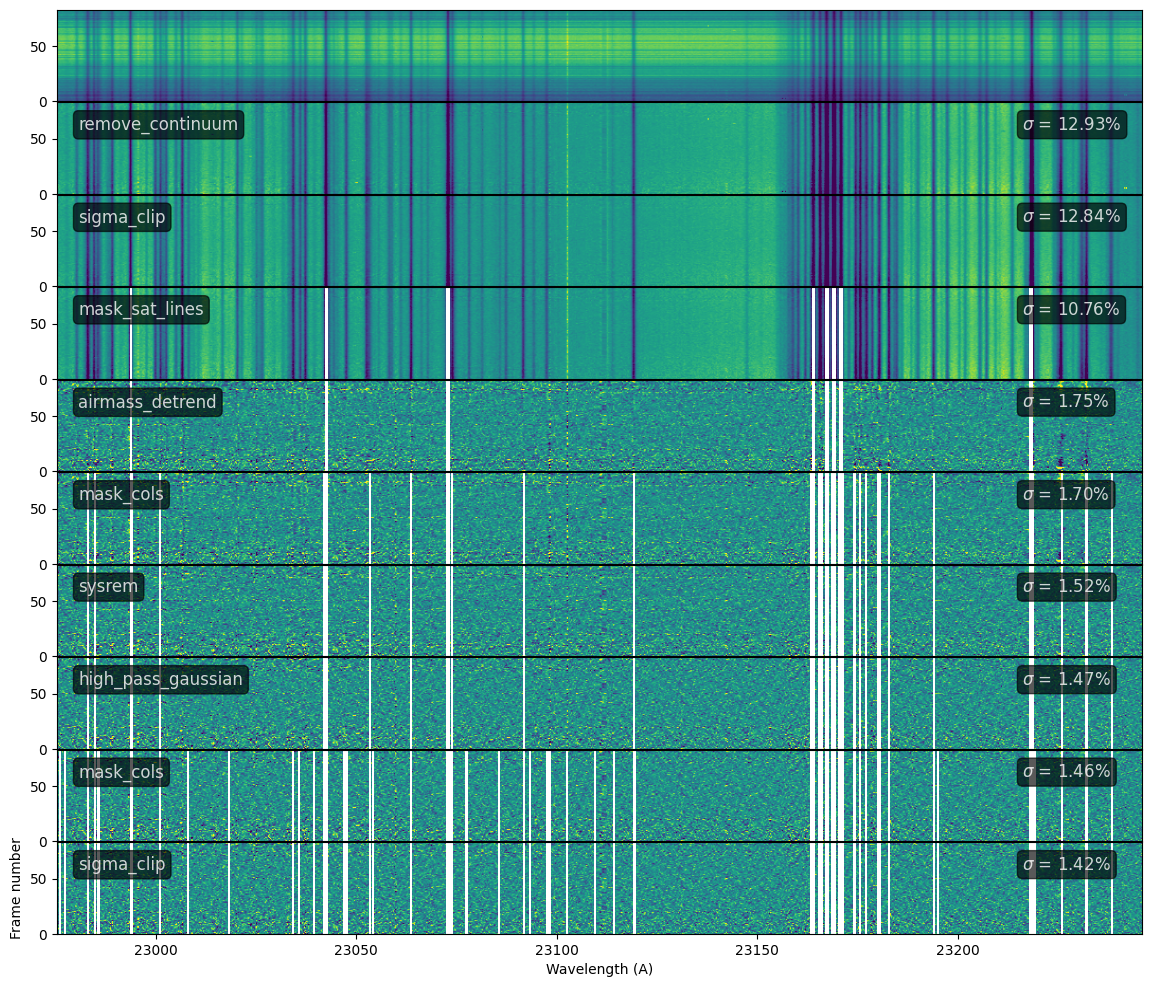

In [6]:
order = 48*2 # pick order, multiply by two since the orders are not splitted

pipeline = Pipeline()

# Add functions with arguments
pipeline.add('remove_continuum', dict(mode='polyfit', deg=7))
pipeline.add('sigma_clip', {'sigma':3}) 
pipeline.add('mask_sat_lines', {'sat':0.60}) 
pipeline.add('airmass_detrend')
pipeline.add('mask_cols', {'sigma':1.2, 'mode':'flux'})
pipeline.add('sysrem', {'n':6})
pipeline.add('high_pass_gaussian', {'window':15})
pipeline.add('mask_cols', {'sigma':2., 'mode':'flux'})
pipeline.add('sigma_clip', {'sigma':3}) 

n = len(pipeline.steps)+1
fig, ax = plt.subplots(n, figsize=(14, n*1.2))
plt.subplots_adjust(hspace=0.01)
[ax[k].set_xticks([]) for k in range(n-1)]
ax[0].set_title('Reduction for order {:}'.format(order))
ax[len(ax)-1].set(xlabel='Wavelength (A)', ylabel='Frame number')

# Call the Pipeline object to a given order
# pass `ax` to display every step (with len(ax) = len(steps)+1))
dco = pipeline.reduce(order, dc, ax=ax)
print('{:.1f} % pixel channels masked'.format(dco.nan_frac*100))